## Imports

In [1]:
import os
import time
import numpy as np
from datetime import date
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

## Constants

In [2]:
image_path = './images'
image_size = (256,256,3)
n_latent_channels = 27
batch_size = 4

## Dataset Generation

In [3]:
def preprocess(train_image):
    train_image = (train_image - 127.5) / 127.5
    return train_image

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function= preprocess
)

image_set = train_datagen.flow_from_directory(
    image_path,
    target_size=image_size[:-1],
    batch_size= batch_size,
    class_mode=None, # since there is no inference data to train against
    shuffle=True,
)



Found 8 images belonging to 1 classes.


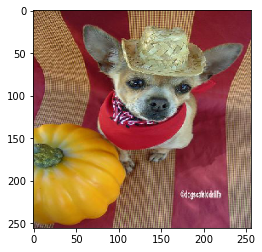

In [5]:
image = image_set[0][0]* 127.5 + 127.5
plt.imshow(image/255)

# Models

### Encoder

In [6]:

class Encoder(keras.Model):
    
    def __init__(self, encoder_channels=27, input_shape=(256,256,3)):
        super(Encoder, self).__init__()
        
        self.dim = input_shape;
        
        # Input: 256x256x3 / Output: 128x128x64
        self.conv1 = Sequential(
            [
                layers.Conv2D(64, kernel_size=5, strides=2, padding='same'),
                layers.LeakyReLU()
            ], name='conv1'
        )

        # Input: 128x128x64 / Output: 64x64x128
        self.conv2 = Sequential(
            [
                layers.Conv2D(128, kernel_size=5, strides=2, padding='same'),
                layers.LeakyReLU()
            ], name='conv2'
        
        )
        
        # Input: 128x128x64 / Output: 64x64x128
        self.block1 = Sequential(
            [
                layers.Conv2D(128, kernel_size=3, strides=1, padding='same'),
                layers.LeakyReLU(),
                layers.Conv2D(128, kernel_size=3, strides=1, padding='same'),
            ], name="block1"
        )

        # Input: 128x128x64 / Output: 64x64x128
        self.block2 = Sequential(        
            [
                layers.Conv2D(128, kernel_size=3, strides=1, padding='same'),
                layers.LeakyReLU(),
                layers.Conv2D(128, kernel_size=3, strides=1, padding='same')
            ], name="block2"
        )

        # Input: 128x128x64 / Output: 64x64x128
        self.block3 = Sequential(
            [
                layers.Conv2D(128, kernel_size=3, strides=1, padding='same'),
                layers.LeakyReLU(),
                layers.Conv2D(128, kernel_size=3, strides=1, padding='same')
            ], name="block3"
        )

        
        # Input: 128x128x64 / Output: 64x64x27
        self.conv3 = Sequential(
            [
                layers.Conv2D(encoder_channels, kernel_size=5, strides=1 ,activation=keras.activations.tanh, padding='same'),       
            ], name='conv3'
        )
        
        
        
        # print(self.conv1.summary())
        # print(self.conv2.summary())
        # print(self.block1.summary())
        # print(self.block2.summary())
        # print(self.block3.summary())        
        # print(self.conv3.summary())
    
    
    def call(self, inputs):
        layer_1 = self.conv1(inputs)
        layer_2 = self.conv2(layer_1)
        layer_3 = layers.Add()([self.block1(layer_2), layer_2])
        layer_4 = layers.Add()([self.block2(layer_3), layer_3])
        layer_5 = layers.Add()([self.block3(layer_4), layer_4])
        layer_6 = self.conv3(layer_5)
        
        
        return layer_6
    
    def build_graph(self):
        x = layers.Input(shape=(self.dim))
        return keras.Model(inputs=[x], outputs=self.call(x))
        
        

input_shape = (None, 256, 256,3)
encoder = Encoder(input_shape=image_size[1:], encoder_channels=n_latent_channels)
encoder.build(input_shape)
encoder.summary()


    
    
    

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Sequential)           (None, 128, 128, 64)      4864      
_________________________________________________________________
conv2 (Sequential)           (None, 64, 64, 128)       204928    
_________________________________________________________________
block1 (Sequential)          (None, 64, 64, 128)       295168    
_________________________________________________________________
block2 (Sequential)          (None, 64, 64, 128)       295168    
_________________________________________________________________
block3 (Sequential)          (None, 64, 64, 128)       295168    
_________________________________________________________________
conv3 (Sequential)           (None, 64, 64, 27)        86427     
Total params: 1,181,723
Trainable params: 1,181,723
Non-trainable params: 0
_________________________________________________

### Generator

In [7]:
INPUT_SHAPE = (64, 64, 27)
OUTPUT_SHAPE = (256, 256, 3)

def generator(INPUT_SHAPE, OUTPUT_SHAPE):
    e_in1 = layers.Input(shape=INPUT_SHAPE)
    con1 = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(e_in1)
    le1 = layers.LeakyReLU()(con1)

    conT1 = layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding='same')(le1)

    def block1(input_tensor):
        bcon1 = layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(input_tensor)
        ble1 = layers.LeakyReLU()(bcon1)
        bcon2 = layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(ble1)
        return bcon2

    def block2(input_tensor):
        bcon1 = layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(input_tensor)
        ble1 = layers.LeakyReLU()(bcon1)
        bcon2 = layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(ble1)
        return bcon2

    def block3(input_tensor):
        bcon1 = layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(input_tensor)
        ble1 = layers.LeakyReLU()(bcon1)
        bcon2 = layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(ble1)
        return bcon2




    dblock1 = layers.Add()([block1(conT1), conT1])
    dblock2 = layers.Add()([block2(dblock1), dblock1])
    dblock3 = layers.Add()([block3(dblock2), dblock2])

    con2 = layers.Conv2D(32, kernel_size=3, strides=1, padding='same')(dblock3)
    le2 = layers.LeakyReLU()(con2)
    conT2 = layers.Conv2DTranspose(32, kernel_size=2, strides=2, padding='same')(le2)

    con3 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same')(conT2)
    le3 = layers.LeakyReLU()(con3)

    con4 = layers.Conv2D(3, kernel_size=3, strides=1, padding='same')(le3)
    out = tf.tanh(con4)

    return keras.Model(inputs=e_in1, outputs=out, name='Generator')


gen = generator(INPUT_SHAPE, OUTPUT_SHAPE)
gen.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 27)] 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 64, 64, 64)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 128, 128, 128 32896       leaky_re_lu_5[0][0]              
__________________________________________________________________________________________

### Discriminator

In [8]:
IMAGE_SIZE = (256, 256, 3)
LATENT_CHANNELS = n_latent_channels



def discriminator(LATENT_CHANNELS):
    # ---------------- Discriminator Model ----------------
    lv = layers.Input(shape= (64, 64, LATENT_CHANNELS))
    ll1 = layers.Conv2DTranspose(12, (3, 3), strides=1, padding='same')(lv)
    ll1_lr = layers.LeakyReLU(alpha=.2)(ll1)
    ll2 = layers.Conv2DTranspose(16, (3, 3), strides=2, padding='same')(ll1_lr)
    ll2_lr = layers.LeakyReLU(alpha=.2)(ll2)
    ll3 = layers.Conv2DTranspose(24, (3, 3), strides=2, padding='same')(ll2_lr)
    ll3_lr = layers.LeakyReLU(alpha=.2)(ll3)
    ll4 = layers.Conv2DTranspose(3, (3, 3), strides=1, padding='same')(ll3_lr)
    ll4_lr = layers.LeakyReLU(alpha=.2)(ll4)

    ri = layers.Input(shape=IMAGE_SIZE)

    cc = layers.Concatenate(-1)([ri, ll4_lr])
    cv1 = layers.Conv2D(32, kernel_size=3, strides=1)(cc)
    cv1_lr = layers.LeakyReLU(alpha=.2)(cv1)
    cv1_lr_d = layers.Dropout(.3, name='drop1')(cv1_lr)

    cv2 = layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(cv1_lr_d)
    cv2_lr = layers.LeakyReLU(alpha=.2)(cv2)
    cv2_lr_d = layers.Dropout(.3, name='drop2')(cv2_lr)

    cv3 = layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(cv2_lr_d)
    cv3_lr = layers.LeakyReLU(alpha=.2)(cv3)
    cv3_lr_d = layers.Dropout(.3, name='drop3')(cv3_lr)

    cv4 = layers.Conv2D(16, kernel_size=3, strides=2)(cv3_lr_d)
    cv4_lr = layers.LeakyReLU(alpha=.2)(cv4)
    cv4_lr_d = layers.Dropout(.3, name='drop4')(cv4_lr)

    cv5 = layers.Conv2D(8, kernel_size=3, strides=2)(cv4_lr_d)
    cv5_lr = layers.LeakyReLU(alpha=.2)(cv5)
    cv5_lr_d = layers.Dropout(.3, name='drop5')(cv5_lr)

    cv_op = tf.nn.tanh(cv5_lr_d)
    fl = layers.Flatten()(cv_op)
    dd1 = layers.Dense(1000, activation='sigmoid')(fl)
    dd2 = layers.Dense(100, activation='sigmoid')(dd1)
    dd3 = layers.Dense(1, activation='sigmoid')(dd2)


    return keras.Model(inputs=[lv, ri], outputs=dd3, name='Discriminator')

disc = discriminator(n_latent_channels)
disc.summary()


Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 27)] 0                                            
__________________________________________________________________________________________________
conv2d_transpose_2 (Conv2DTrans (None, 64, 64, 12)   2928        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 64, 64, 12)   0           conv2d_transpose_2[0][0]         
__________________________________________________________________________________________________
conv2d_transpose_3 (Conv2DTrans (None, 128, 128, 16) 1744        leaky_re_lu_11[0][0]             
______________________________________________________________________________________

# Optimizers and Loss

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mean_absolute_error = tf.keras.losses.MeanAbsoluteError()

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [11]:
def generator_loss(fake_output, real_image, fake_image):
    return cross_entropy(tf.ones_like(fake_output), fake_output) + 2*mean_absolute_error(real_image, fake_image)

In [12]:
# def encoder_loss(fake_output, real_image, fake_image):
#         return cross_entropy(tf.ones_like(fake_output), fake_output) + 2*mean_absolute_error(real_image, fake_image)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
encoder_optimizer = tf.keras.optimizers.Adam(1e-4)

# Initialize models

In [14]:
encoder = Encoder(input_shape=image_size[1:], encoder_channels=n_latent_channels)
discriminator = discriminator(n_latent_channels)
generator = generator(INPUT_SHAPE, OUTPUT_SHAPE)

# Checkpoint

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 encoder_optimizer=encoder_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 encoder=encoder)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

In [16]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(real_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as enc_tape:
        
        # discriminator
        real_encoded = encoder(real_images, training=True)
        generated_images = generator(real_encoded, training=True)

        real_in = [real_encoded, real_images]
        fake_in = [real_encoded, generated_images]


        real_out = discriminator(real_in, training=True)
        fake_out = discriminator(fake_in, training=True)

        disc_loss = discriminator_loss(real_out,fake_out)

        # Generator
        gen_loss = generator_loss(fake_out, real_images, generated_images)
            

    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))

    enc_grads = enc_tape.gradient(gen_loss, encoder.trainable_variables)
    encoder_optimizer.apply_gradients(zip(enc_grads, encoder.trainable_variables))
        


In [17]:
def generate_and_save_images(generator, encoder, epoch, test_input):
    encoded = encoder(test_input, training=False)
    predictions = generator(encoded, training=False)


    fig = plt.figure(figsize=(5, 5))

    for i in range(predictions.shape[0]):
        plt.subplot(1, 4, i+1)
        plt.imshow((predictions[i, :, :, 0] * 127.5 + 127.5)/255)
        plt.axis('off')
    
    plt.savefig('results/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    
    compare = np.hstack([test_input[0], predictions[0]])
    compare = compare*127.5 + 127.5
    array_to_img(compare).save(f'results/{str(date.today())}_{epoch}_generated_image.png')

steps_per_epoch = 2
def train(dataset, epochs):
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    
    print('Training Started!')
    for epoch in tqdm(range(epochs), desc='Epoch'):
        print(f'Epoch {epoch} started!')
        start = time.time()

        for i, image_batch in enumerate(tqdm(dataset, desc='Train Step')):
            train_step(image_batch)
            if i >= steps_per_epoch:  # manually detect the end of the epoch
                break  
        dataset.on_epoch_end()

        generate_and_save_images(generator, encoder,epoch + 1,image_set[0])

        # Save the model every 15 epochs
        if (epoch + 1) % 3 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


    generate_and_save_images(generator, encoder, epochs, image_set[0])

Restored from ./training_checkpoints\ckpt-6
Training Started!


Outer:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 0 started!


Inner: 0it [00:00, ?it/s]

(1, 256, 256, 3)


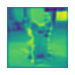

Time for epoch 1 is 53.848283767700195 sec
Epoch 1 started!


Inner: 0it [00:00, ?it/s]

(1, 256, 256, 3)


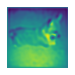

Time for epoch 2 is 46.589720010757446 sec
Epoch 2 started!


Inner: 0it [00:00, ?it/s]

(1, 256, 256, 3)


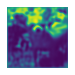

Time for epoch 3 is 46.947476625442505 sec
Epoch 3 started!


Inner: 0it [00:00, ?it/s]

(1, 256, 256, 3)


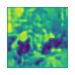

Time for epoch 4 is 44.97718095779419 sec
Epoch 4 started!


Inner: 0it [00:00, ?it/s]

(1, 256, 256, 3)


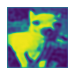

Time for epoch 5 is 46.37474775314331 sec
Epoch 5 started!


Inner: 0it [00:00, ?it/s]

(1, 256, 256, 3)


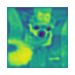

Time for epoch 6 is 48.41880416870117 sec
Epoch 6 started!


Inner: 0it [00:00, ?it/s]

(1, 256, 256, 3)


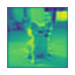

Time for epoch 7 is 43.37184143066406 sec
Epoch 7 started!


Inner: 0it [00:00, ?it/s]

(1, 256, 256, 3)


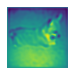

Time for epoch 8 is 43.497884035110474 sec
Epoch 8 started!


Inner: 0it [00:00, ?it/s]

(1, 256, 256, 3)


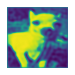

Time for epoch 9 is 42.91330099105835 sec
(1, 256, 256, 3)


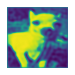

In [18]:
EPOCHS = 9
train(image_set, EPOCHS)

## TODO

- change notebook tqdm to normal tqdm
- Inner tqdm
